In [12]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline
plt.style.use('seaborn')

In [13]:
df_raw = pd.read_csv('data/wa_ev_registrations_public.csv')
df_raw = df_raw[(df_raw.Technology == 'BEV')]
df_raw.head()
df_raw['Vehicle Name'].value_counts()

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (2,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Tesla Model 3                521229
Nissan Leaf                  494796
Tesla Model S                249823
Tesla Model Y                142192
Chevrolet Bolt EV            128566
Tesla Model X                115386
Volkswagen e-Golf             33621
Kia Soul EV                   31295
BMW i3                        30029
Fiat 500e                     28154
Kia Niro EV                   22125
Audi e-tron                   13649
Ford Focus EV                 12971
Smart forTwo EV               10045
Chevrolet Spark                9209
Ford Mustang Mach-E            7492
Hyundai Kona Electric          7146
Volkswagen ID.4                6687
Jaguar I-Pace                  5458
Mercedes B-Class Electric      3916
Mini Hardtop 2 Door EV         3614
Volvo XC40 Recharge            3526
Porsche Taycan                 3508
Mitsubishi i                   3429
Tesla Roadster                 2961
Toyota RAV4 EV                 2507
Polestar 2                     1928
Audi e-tron Sportback       

In [14]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2010-01-06,1.0
2010-02-03,1.0
2010-02-11,1.0
2010-02-16,3.0
2010-03-03,1.0
...,...
2022-02-25,62758.0
2022-03-16,66305.0
2022-04-26,67786.0


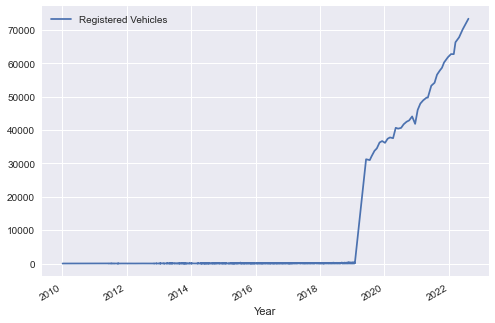

In [15]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df

In [16]:
df.shape

(2381, 1)

In [17]:
# df.shift(2).shape
# df = pd.DataFrame(np.hstack((df.values.reshape(-1,1),
#                             df.shift().values.reshape(-1,1),
#                             df.shift(periods=2).values.reshape(-1,1))),
#                         columns = ['Original', '1 shift', '2 shifts'])
# df.head()
# print(np.sqrt(mean_squared_error(df['Original'][1:], df['1 shift'][1:])))
# print(np.sqrt(mean_squared_error(df['Original'][2:], df['2 shifts'][2:])))

In [18]:
auto_model = pm.auto_arima(df, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=48293.894, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=45382.780, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=37791.905, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.80 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=37781.588, Time=0.65 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=43357.870, Time=0.93 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.47 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=37766.397, Time=0.97 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=41965.532, Time=1.25 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=37774.752, Time=1.07 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=37764.504, Time=0.81 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=2.60 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=37767.334, Time=0.85 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=3

## **RESAMPLING

In [19]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [20]:
# # Backfill 
# df = df.resample('M').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

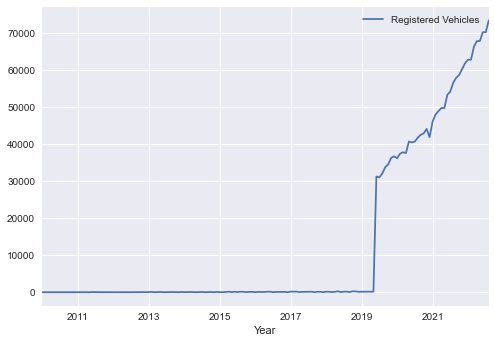

In [21]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

## Testing 

In [22]:
adtest = adfuller(df)
display(adtest)

(1.8022931264543838,
 0.9983535542710279,
 0,
 151,
 {'1%': -3.4744158894942156,
  '5%': -2.880878382771059,
  '10%': -2.577081275821236},
 2560.2613305406817)

## Modeling

In [24]:
# Splitting Training and Testing data; using after 2019 as test

train = df['2018-06-30':'2020-12-31']
test = df['2020-12-31':]
combined = df

test

,Registered Vehicles
Year,
2020-12-31,41853.0
2021-01-31,46040.0
2021-02-28,47930.0
2021-03-31,48898.0
2021-04-30,49726.0
2021-05-31,49726.0
2021-06-30,53283.0
2021-07-31,54170.0
2021-08-31,56587.0


In [25]:
naive = train.shift(1)
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

5761.182158781882

In [26]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=728.708, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=631.817, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=713.176, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=633.837, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=633.989, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=634.580, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.276 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   31
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -313.909
Date:                Thu, 10 Nov 2022   AIC                            631.817
Time:                        02:01:49   BIC                            634.685
Sample:                    06-30-2

### The best model is :  ARIMA (1,0,0) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0147      0.176      5.762      0.000       0.670       1.360
sigma2      3.301e+07   2.29e+06     14.397      0.000    2.85e+07    3.75e+07


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


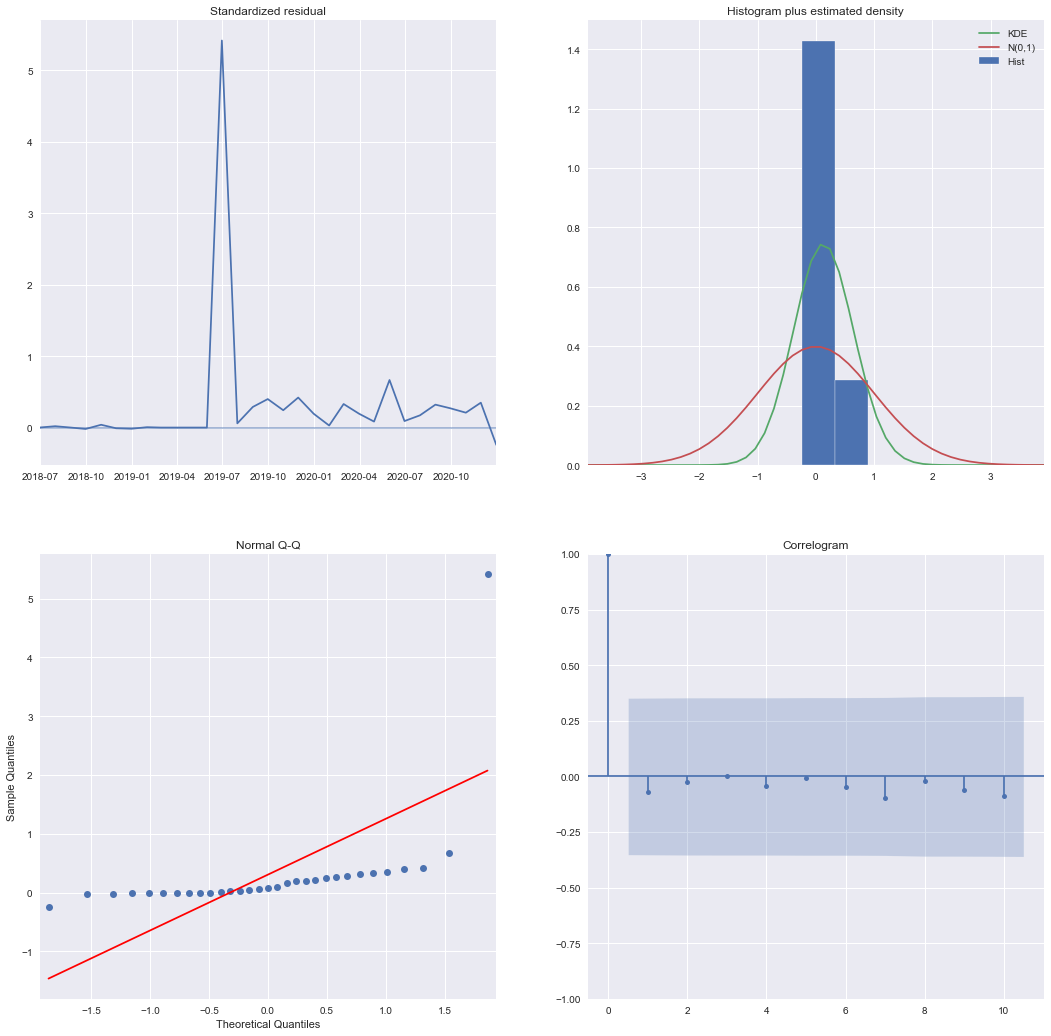

In [27]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(1,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [28]:
pred = output.get_prediction(start=pd.to_datetime('2021-01-31'), end=pd.to_datetime('2022-08-31'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2021-01-31,31206.572181,53727.043309
2021-02-28,27048.042731,59131.192211
2021-03-31,23929.433054,63513.689348
2021-04-30,21338.969646,67386.576137
2021-05-31,19079.800458,70946.976471
2021-06-30,17051.604164,74295.487507
2021-07-31,15195.133709,77491.636177
2021-08-31,13471.996294,80574.099260
2021-09-30,11855.658603,83569.698218
2021-10-31,10326.891476,86497.954583


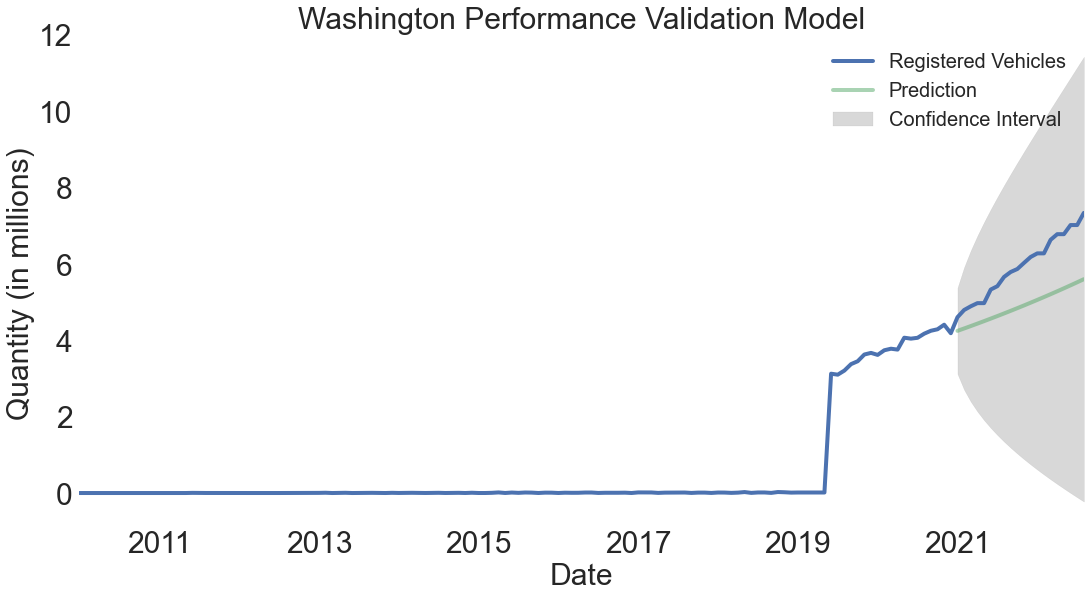

In [29]:
sns.set_style(style='white')

rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in millions) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e4
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Washington Performance Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()

In [30]:
# Beginning our forecasting for next 3 years (36 months)
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(combined, 
                                        order=(2,0,1), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


full_output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0147      0.176      5.762      0.000       0.670       1.360
sigma2      3.301e+07   2.29e+06     14.397      0.000    2.85e+07    3.75e+07


In [31]:
forecast = full_output.get_forecast(36)
future_prediction = forecast.conf_int()
future_prediction['value'] = forecast.predicted_mean
future_prediction.columns = ['lower','upper','prediction'] 
future_prediction

,lower,upper,prediction
2022-09-30,69832.707920,80146.051945,74989.379932
2022-10-31,69574.329297,83941.132054,76757.730676
2022-11-30,69706.862969,87395.916427,78551.389698
2022-12-31,70091.709971,90687.183713,80389.446842
2023-01-31,70643.084673,93897.189088,82270.136881
2023-02-28,71321.990027,97067.774478,84194.882252
2023-03-31,72104.794504,100224.503937,86164.649221
2023-04-30,72976.522884,103384.478809,88180.500846
2023-05-31,73927.039686,106559.987946,90243.513816
2023-06-30,74949.227009,109760.356411,92354.791710


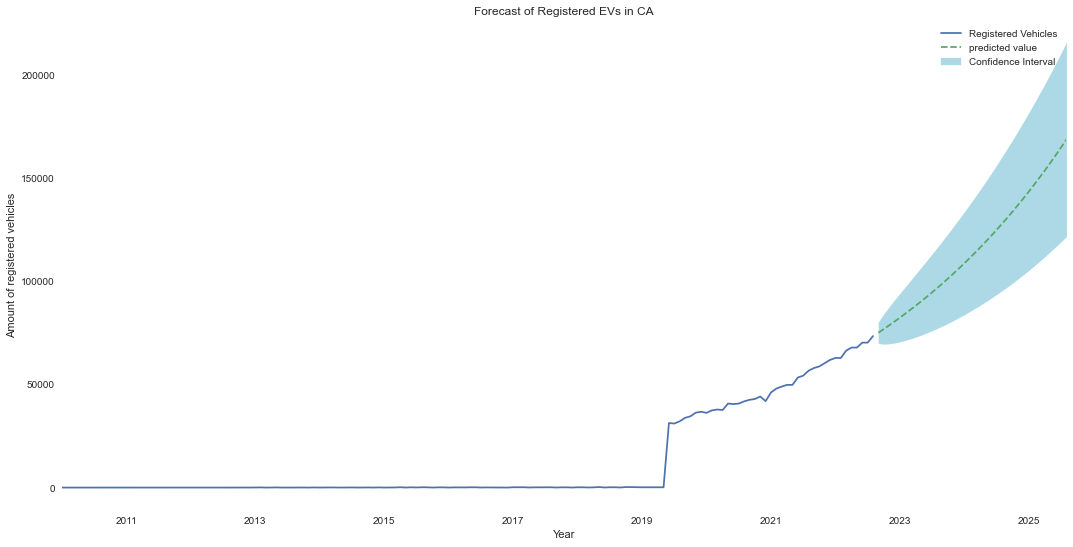

In [32]:
fig, ax = plt.subplots()
combined.plot(ax=ax,label='Observed')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'],color='lightblue',
                label='Confidence Interval')
scale_y = 1e6
ax.legend() 
plt.ylabel("Amount of registered vehicles")
plt.title('Forecast of Registered EVs in CA')
plt.show()

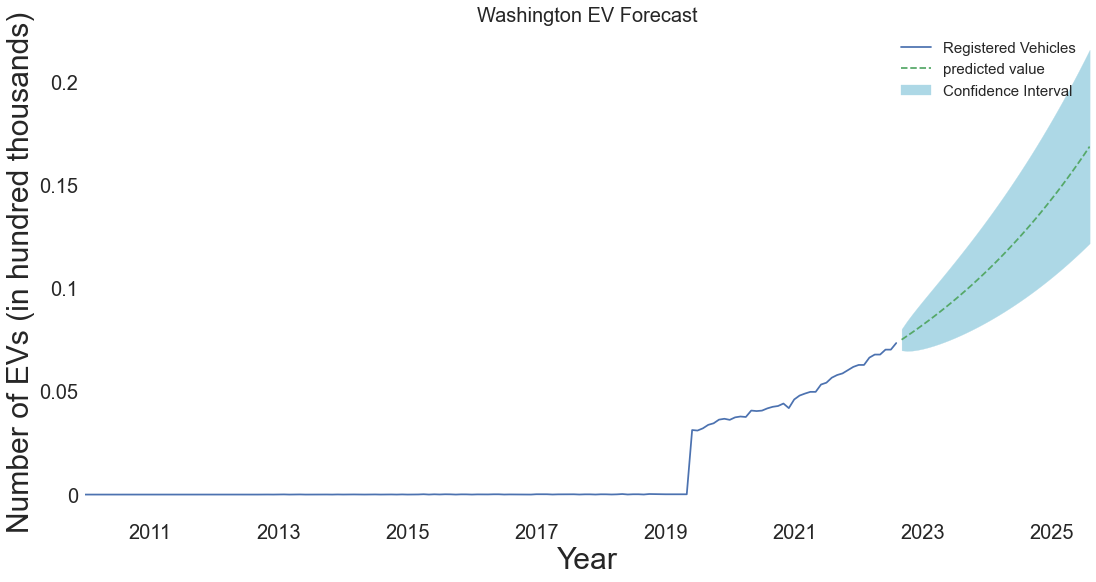

In [33]:
sns.set_style(style='white')
fig, ax = plt.subplots()
combined.plot(ax=ax,label='Actual')


future_prediction['prediction'].plot(ax=ax,label='predicted value',ls='--')

ax.fill_between(x= future_prediction.index, y1= future_prediction['lower'], 
                y2= future_prediction['upper'], color = 'lightblue',
                label='Confidence Interval')


ax.set_xlabel('Year',fontsize=30)
plt.xticks(fontsize=20)
ax.set_ylabel('Number of EVs (in hundred thousands)',fontsize=30)
plt.yticks(fontsize=20)

# scale_y = 1e5
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Washington EV Forecast',fontsize=20)
plt.legend(fontsize = 15)
plt.show()